In [121]:
from windData import WindDataCollector
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.utils.set_random_seed(1)

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import math
import pandas as pd

from influxdb import InfluxDBClient

import datetime

import timeit

In [122]:
def eval_metrics(actual, pred):
	rmse = np.sqrt(mean_squared_error(actual, pred))
	mae = mean_absolute_error(actual, pred)
	r2 = r2_score(actual, pred)
	return rmse, mae, r2


In [123]:
start_time = datetime.datetime(2021, 1, 1, 0, 0, 0).strftime("'%Y-%m-%dT%H:%M:%SZ'")

dataCollector = WindDataCollector()

gen_df = dataCollector.getGenerationData(now = start_time, delta="90")
wind_df = dataCollector.getWindData(now = start_time, delta="90")

gen_df_alligned = pd.merge_asof(wind_df,gen_df,left_index=True, right_index=True)

In [124]:
train_length = int(len(gen_df_alligned)*0.9)

train_X = gen_df_alligned.iloc[:train_length][[
#    "Direction",
    "Speed"]]
test_X = gen_df_alligned.iloc[train_length:][[
#    "Direction",
    "Speed"]]

train_y = gen_df_alligned.iloc[:train_length]["Total"]
test_y = gen_df_alligned.iloc[train_length:]["Total"]

## MLP

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

### Data prep and functions

In [125]:
normalizer = tf.keras.layers.Normalization(axis=-1)
windspeed = train_X["Speed"].to_numpy()
windspeed_normalizer = layers.Normalization(input_shape=[1,], axis=None)
windspeed_normalizer.adapt(windspeed)

In [126]:
def plot_loss(history, title):
  plt.figure(figsize=(5,2))
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.ylim([0, 12.5])
  plt.xlabel('Epoch')
  plt.ylabel('MAE [MW]')
  plt.title(title)
  plt.legend()
  plt.grid(True)
  plt.savefig(title + ".pdf", bbox_inches='tight') # last part makes sure that the whole fig is saved.
  plt.show()

In [127]:
def plot_loss_compared(hist1, hist2):
  plt.plot(hist1.history['loss'], label='GD loss', color = "#0081C9", alpha = 0.8)
  plt.plot(hist2.history['loss'], label='SGD loss', color = "black", alpha = 0.8)
  #plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [128]:
# def build_and_compile_model_GD(norm):
#   model = keras.Sequential([
#       norm,
#       layers.Dense(32, activation='relu'),
#       layers.Dense(16, activation='relu'),
#       layers.Dense(1)
#   ])

#   model.compile(loss='mean_absolute_error',
#                 optimizer=tf.compat.v1.train.GradientDescentOptimizer(0.1))
#   return model


# def build_and_compile_model_SGD(norm):
#   model = keras.Sequential([
#       norm,
#       layers.Dense(32, activation='relu'),
#       layers.Dense(16, activation='relu'),
#       layers.Dense(1)
#   ])

#   model.compile(loss='mean_absolute_error',
#                 optimizer=tf.keras.optimizers.experimental.SGD(0.1))
#   return model

## Gradient descent

In [129]:
# dnn_windspeed_model_GD = build_and_compile_model_GD(windspeed_normalizer)

In [130]:
# power_GD = dnn_windspeed_model_GD.fit(
#     train_X['Speed'],
#     train_y,
#     validation_split=0.2,
#     verbose=0, 
#     epochs=50,
#     batch_size = len(wind_df),
#     steps_per_epoch = 1,
#     )

In [131]:
# plot_loss(power_GD)

In [132]:
# predictions = dnn_windspeed_model_GD.predict(test_X["Speed"])
# (rmse, mae, r2) = eval_metrics(test_y, predictions)
# print("  RMSE: %s" % rmse)
# print("  MAE: %s" % mae)
# print("  R2: %s" % r2)

## Stochastic Gradient Descent

In [133]:
# dnn_windspeed_model_SGD = build_and_compile_model_SGD(windspeed_normalizer)

In [134]:
# power_SGD = dnn_windspeed_model_SGD.fit(
#     train_X['Speed'],
#     train_y,
#     validation_split=0.2,
#     verbose=0, 
#     epochs=3000,
#     batch_size = 1,
#     steps_per_epoch = 1,
#     )

In [135]:
# plot_loss(power_SGD)

In [136]:
# predictions = dnn_windspeed_model_SGD.predict(test_X["Speed"])
# (rmse, mae, r2) = eval_metrics(test_y, predictions)
# print("  RMSE: %s" % rmse)
# print("  MAE: %s" % mae)
# print("  R2: %s" % r2)

In [137]:
# plot_loss_compared(power_GD, power_SGD)

# New experiments, with batch_size, steps_per_epoch etc.

## Gradient Descent

In [138]:
# For dedfining batch size and steps per epoch we need the size of the training set. 
val_split = 0.8
len_train_X = int( len(train_X) * val_split )

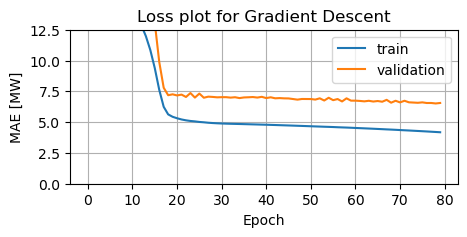

2/2 [==============================] - 0s 2ms/step
  RMSE: 4.792014678895554
  MAE: 3.994098287202865
  R2: 0.8625611740255095


In [139]:
tf.keras.utils.set_random_seed(1)

def build_and_compile_model_GD(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.experimental.SGD(0.1))
  return model

dnn_windspeed_model_GD = build_and_compile_model_GD(windspeed_normalizer)

power_GD = dnn_windspeed_model_GD.fit(
    train_X['Speed'],
    train_y,
    validation_split=0.2,
    verbose=0, 
    epochs=80,
    batch_size = len_train_X,
    steps_per_epoch = 1, # it is default value (batch_size / len(train)) = 1
    )

plot_loss(power_GD, "Loss plot for Gradient Descent")

predictions = dnn_windspeed_model_GD.predict(test_X["Speed"])
(rmse, mae, r2) = eval_metrics(test_y, predictions)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

## Stochastic Gradient Descent

In [140]:
# Learning rate 0.1 -- Too much noise, every datapoint gets too much influence

# tf.keras.utils.set_random_seed(42)

# def build_and_compile_model_SGD(norm):
#   model = keras.Sequential([
#       norm,
#       layers.Dense(32, activation='relu'),
#       layers.Dense(16, activation='relu'),
#       layers.Dense(1)
#   ])

#   model.compile(loss='mean_absolute_error',
#                 optimizer=tf.keras.optimizers.experimental.SGD(0.1))
#   return model

# dnn_windspeed_model_SGD = build_and_compile_model_SGD(windspeed_normalizer)

# power_SGD = dnn_windspeed_model_SGD.fit(
#     train_X['Speed'],
#     train_y,
#     validation_split=0.2,
#     verbose=0, 
#     epochs=80,
#     batch_size = 1,
#     steps_per_epoch = len_train_X, # it is default value (batch_size / len(df)) = len(df)
#     )

# plot_loss(power_SGD)

# predictions = dnn_windspeed_model_SGD.predict(test_X["Speed"])
# (rmse, mae, r2) = eval_metrics(test_y, predictions)
# print("  RMSE: %s" % rmse)
# print("  MAE: %s" % mae)
# print("  R2: %s" % r2)

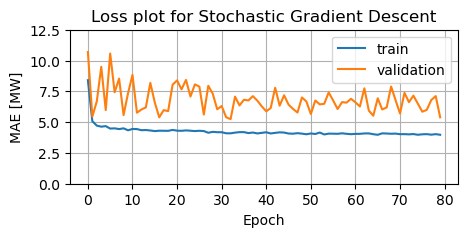

2/2 [==============================] - 0s 2ms/step
  RMSE: 3.9807588611957905
  MAE: 3.1211473009847004
  R2: 0.9051570839665514


In [141]:
# Learning rate 0.01 -- Better, very datapoint gets a bit less influence.

tf.keras.utils.set_random_seed(1)

def build_and_compile_model_SGD(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.experimental.SGD(0.01))
  return model

dnn_windspeed_model_SGD = build_and_compile_model_SGD(windspeed_normalizer)

power_SGD = dnn_windspeed_model_SGD.fit(
    train_X['Speed'],
    train_y,
    validation_split=0.2,
    verbose=0, 
    epochs=80,
    batch_size = 1,
    steps_per_epoch = len_train_X, # it is default value (batch_size / len(df)) = len(df)
    )

plot_loss(power_SGD, "Loss plot for Stochastic Gradient Descent")

predictions = dnn_windspeed_model_SGD.predict(test_X["Speed"])
(rmse, mae, r2) = eval_metrics(test_y, predictions)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

## Mini-batch Gradient Descent

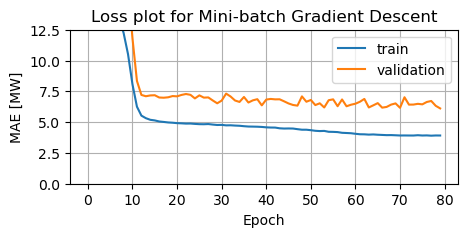

2/2 [==============================] - 0s 1ms/step
  RMSE: 4.3258614544932845
  MAE: 3.4976446955079576
  R2: 0.8879999105864458


In [142]:
tf.keras.utils.set_random_seed(1)

def build_and_compile_model_MGD(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.experimental.SGD(0.01))
  return model

dnn_windspeed_model_MGD = build_and_compile_model_MGD(windspeed_normalizer)

power_MGD = dnn_windspeed_model_MGD.fit(
    train_X['Speed'],
    train_y,
    validation_split=0.2,
    verbose=0, 
    epochs=80,
    batch_size = 32, # this is the default value
    # steps_per_epoch # when commented out and set to default value it calculated = (batch_size / len(df)).
    )

plot_loss(power_MGD, "Loss plot for Mini-batch Gradient Descent")

predictions = dnn_windspeed_model_MGD.predict(test_X["Speed"])
(rmse, mae, r2) = eval_metrics(test_y, predictions)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)
%timeit